## The cell below contains all functions required for de Groot, OSA control, Gauss-Seidel
- rowsum(A) calculates the rowsum of the matrix A
- colsum(A) calculates the column sum of the matrix A
- rs_ize(A) returns a row stochastic matrix from a given nonnegative matrix A
- x_os = COD_OSA_1p_update(x_os,targ,γ,A,b)
- x_os = COD_OSA_GS(x_init,targets,γ,K_f,A,B,proj_flag)


In [1]:
using PyPlot
using LinearAlgebra
using JuMP
using Ipopt
using Statistics
using RandomMatrices
using BirkhoffDecomposition
using Permutations

In [2]:
function rowsum(A) #Returns a column vector containing the row sums of square matrix A
    m = size(A,1)
    rowsum = zeros(m,1)
    for i in 1:m
        rowsum[i] = sum(A[i,:])
    end
    return rowsum
end
####################################
function colsum(A) #Returns a column vector containing the column sums of square matrix A
    n = size(A,2)
    colsum = zeros(n,1)
    for i in 1:n
        colsum[i] = sum(A[:,i])
    end
    return colsum
end
####################################
function rs_ize(A) #Returns a row stochastic matrix, given a nonnegative matrix A
    rsA = rowsum(A)
    A = inv(diagm(vec(rsA)))*A  #A is row stochastic
    return A
end
####################################
function approx_proj(b,γ) #Returns the approximate projection P_tilde(b_i,gamma_i), b_i a vector, gamma_i a scalar.
    Ptb = (1/(b'*b + γ))*b*b'
    return Ptb
end
####################################
function A_cl_J(A,B,Γ) #Returns the closed-loop matrix for the Jacobi procedure
    #A is the n by n agent stochastic matrix, B n by p player influence matrix, Γ a p vector of control weights
    N_a = size(A,1)
    N_p = size(B,2)
    P = zeros(N_a,N_a)
    for i in 1:N_p
        P = P + approx_proj(B[:,i],Γ[i])
    end
    Ac = (I(N_a) - P)*A
    return Ac
end
####################################
function A_cl_G(A,B,Γ,perm) #Returns the closed-loop matrix for the Jacobi procedure
    #A is the n by n agent stochastic matrix, B n by p player influence matrix, Γ a p vector of control weights
    N_a = size(A,1)
    N_p = size(B,2)
    P = A
    for i in 1:N_p
        P = approx_proj(B[:,perm[i]],Γ[perm[i]])*P
    end
    Ac = P
    return Ac
end
####################################
function test_conjecture(N_a,N_p,N_test)
    #This function tests, N_test times, the conjecture that it is enough to have A row stochastic for rho(A_cl)<1
    ctr_ex = 0
    A_fcx = zeros(N_a,N_a)
    B_fcx = zeros(N_a,N_p)
    Γ_fcx = zeros(N_p)
    for i in 1:N_test
        A = 2*rand(N_a,N_a) #random N_a by N_a matrix
        A = rs_ize(A) #Makes A row stochastic
        B = 2*rand(N_a,N_p) #Random N_a by N_p matrix
        Γ = rand(N_p) #Random vector of control weights
        A_cl = A_cl_J(A,B,Γ)
        if maximum(abs.(eigvals(A_cl))) > 1
            ctr_ex = ctr_ex +1
            A_fcx = A
            B_fcx = B
            Γ_fcx = Γ
        end
    end
    return A_fcx, B_fcx, Γ_fcx, ctr_ex
end
        
####################################
function offsetJ(B,Γ,G)
    N_a = size(A,1)
    N_p = size(B,2)
    d = zeros(N_a)
    for i in 1:N_p
        d = d + approx_proj(B[:,i],Γ[i])*G[:,i]
    end
    return d
end
####################################
#Control of opinion dynamics control in social network
####################################
#COD = controlled opinion dynamics
#OSA = one step ahead
#x_os = current state 
#targ = vector of targets for 1 player
#b = input coupling vector for 1 player
#This function is set up to update agent states under the action of one player
#Written for the case of one player at a time, OSA, Gauss-Seidel updates
function COD_OSA_1p_update(x_os,targ,γ,A,b)
#Initialize arrays
    N_a = length(x_os) #Number of agents
    S = Model(Ipopt.Optimizer)
    set_optimizer_attributes(S, "print_level" => 0 )
    #Define the optimization variables
    @variable(S, v) #v is the scalar value of the control for player p
    @variable(S, xn[1:N_a]) #xn is the new state of agent influenced by p
    #Define the control constraints
    #@constraint(S, u_min <= v <= u_max)
    #Define the dynamics as an equality constraint
    @constraint(S, xn .== A*x_os + b*v)
    #Define the objective function for agent p
    @objective(S, Min, sum((xn - targ).^2) + γ*v*v) #****************************************
    optimize!(S)
    #Retrieve optimal values for current control
    #u_os = JuMP.value.(S[:v])
    x_os = JuMP.value.(S[:xn]) #Next state (without projection)
    return x_os
end
############################################################
#Projection of vector x_os onto the hypercube [-1,1]^n
function hyp_proj(x_os)
    for i in 1:length(x_os)
        if x_os[i] >= 1
            x_os[i] = 1
        end
        if x_os[i] <= -1
            x_os[i] = -1
        end
    end
    return x_os
end
##########################################################
#Gauss-Seidel agent updates, one player at a time
#COD = controlled opinion dynamics, GS = Gauss-Seidel information flow; one player updates at a time
function COD_OSA_GS(x_init,targets,γ,K_f,A,B,proj_flag,perm_flag)
#Initialize arrays
    N_a = length(x_init) #Number of agents
    N_p = size(targets,2) #Number of players: player_targets is an n by p matrix of targets for the p players
    x_os = zeros(N_a,K_f + 1)  #Column j: opinions of N_a agents at instant j, Row i: time evolution of agent i's opinion
    u_os = zeros(N_p,K_f)      #Column j: controls of N_p players at instant j, Row i: time evolution of player i's controls
    x_os[:,1] = x_init         #Initial states (opinions) of each agent
    x_temp = zeros(length(x_init)) #temporary state, as each agent updates and passes on to the next agent
    for k in 1:K_f #Time loop
        x_temp = x_os[:,k] #Temp. state set to current state
        for p in 1:N_p #player loop
            if perm_flag == 1
                p_reord = RandomPermutation(N_p)
            else
                p_reord = 1:1:N_p
            end
            x_temp = COD_OSA_1p_update(x_temp,targets[:,p_reord[p]],γ[p_reord[p]],A,B[:,p_reord[p]])  #This is executed N_p times
            if proj_flag == 1
                x_temp = hyp_proj(x_temp) #If the projection flag is set to one, each new x_temp is cut to size by projection
            end
        end
        x_os[:,k+1] = x_temp #Here the N_p times updated temp state becomes the current state at iteration k+1
    end
    return x_os
end
##########################################################
#Gauss-Seidel agent updates, one player at a time
#COD = controlled opinion dynamics, GS = Gauss-Seidel information flow; one player updates at a time
function COD_OSA_GS_1p(x_init,targets,γ,K_f,A,B,proj_flag,perm_flag)
#Initialize arrays
    N_a = length(x_init) #Number of agents
    N_p = size(targets,2) #Number of players: player_targets is an n by p matrix of targets for the p players
    x_os = zeros(N_a,K_f + 1)  #Column j: opinions of N_a agents at instant j, Row i: time evolution of agent i's opinion
    u_os = zeros(N_p,K_f)      #Column j: controls of N_p players at instant j, Row i: time evolution of player i's controls
    x_os[:,1] = x_init         #Initial states (opinions) of each agent
    x_temp = zeros(length(x_init)) #temporary state, as each agent updates and passes on to the next agent
    for k in 1:K_f #Time loop
        x_temp = x_os[:,k] #Temp. state set to current state
        if perm_flag == 1
            p_reord = RandomPermutation(N_p)
        else
            p_reord = 1:1:N_p
        end
        for p in 1:N_p #player loop
            x_temp = COD_OSA_1p_update(x_temp,targets[:,p_reord[p]],γ[p_reord[p]],A,B[:,p_reord[p]])  #This is executed N_p times
            if proj_flag == 1
                x_temp = hyp_proj(x_temp) #If the projection flag is set to one, each new x_temp is cut to size by projection
            end
        end
        x_os[:,k+1] = x_temp #Here the N_p times updated temp state becomes the current state at iteration k+1
    end
    return x_os
end
##########################################################
#COD = controlled opinion dynamics, GS = Gauss-Seidel information flow; one player updates at a time
function COD_OSA_GS_1perm(x_init,targets,γ,K_f,A,B,proj_flag)
#Initialize arrays
    N_a = length(x_init) #Number of agents
    N_p = size(targets,2) #Number of players: player_targets is an n by p matrix of targets for the p players
    x_os = zeros(N_a,K_f + 1)  #Column j: opinions of N_a agents at instant j, Row i: time evolution of agent i's opinion
    u_os = zeros(N_p,K_f)      #Column j: controls of N_p players at instant j, Row i: time evolution of player i's controls
    x_os[:,1] = x_init         #Initial states (opinions) of each agent
    p_reord = RandomPermutation(N_p)
    x_temp = zeros(length(x_init)) #temporary state, as each agent updates and passes on to the next agent
    for k in 1:K_f #Time loop
        x_temp = x_os[:,k] #Temp. state set to current state
        for p in 1:N_p #player loop
            x_temp = COD_OSA_1p_update(x_temp,targets[:,p_reord[p]],γ[p_reord[p]],A,B[:,p_reord[p]]) 
            if proj_flag == 1
                x_temp = hyp_proj(x_temp)
            end
        end
       x_os[:,k+1] = x_temp #Here the N_p times updated temp state becomes the current state at iteration k+1 
    end
    return x_os, p_reord
end
##########################################################
#Control of opinion dynamics control in social network: OSA, DeGroot, Jacobi approach
#COD = controlled opinion dynamics, J = Jacobi information exchange; targets for players are specified
function COD_OSA_J_targets_DeGroot(x_init,targets,γ,K_f,A,B,u_min,u_max,proj_flag)
    #Initialize arrays
    N_a = size(A,1)
    N_p = size(B,2)
    x_os = zeros(N_a,K_f + 1)  #Column j: opinions of N_a agents at instant j, Row i: time evolution of agent i's opinion
    u_os = zeros(N_p,K_f)      #Column j: controls of N_p players at instant j, Row i: time evolution of player i's controls
    x_os[:,1] = x_init         #Initial states (opinions) of each agent
    temp = zeros(N_a,K_f+1)        #Temporary vector to projection
    temp[:,1] = x_init
    for k in 1:K_f #Time loop
            for p in 1:N_p #player loop
                #Name the model, define the solver and set its attributes
                S = "$p"
                S = Model(Ipopt.Optimizer)
                set_optimizer_attributes(S, "print_level" => 0 )
            
                #Define the optimization variables
                @variable(S, v) #v is the scalar value of the control for player p
                @variable(S, xn[1:N_a,1:1]) #xn is the new state of agent influenced by p
            
                #Define the control constraints
                @constraint(S, u_min <= v <= u_max)
            
                #Define the dynamical constraint
                @constraint(S, xn .== A*x_os[:,k] + B[:,p]*v)
                @constraint(S, 0 .<= xn .<= 1 ) #Restrição nas opiniões
                #Define the objective function for each agent
                @objective(S, Min, sum((xn - targets[:,p]).^2) + γ[p]*v*v)
            
                optimize!(S)
            
                #Retrieve optimal values for k-th iteration (instant)
                u_os[p,k] = JuMP.value.(S[:v])
            end
        if proj_flag == 1
            x_os[:,k+1] = hyp_proj(A*x_os[:,k] + B*u_os[:,k])
        else
            x_os[:,k+1] = A*x_os[:,k] + B*u_os[:,k]
        end
    end
    return x_os, u_os
end
##########################################################
function JMGW_Stochastic_matrix_generator_complete_graph(influence_coeffs)
    #JMGW = Jiang,Mazalov,Gao,Wang 23: uses Def 1 of paper
    #N1,N2,N3 are the three neighbors of the four nodes [to be replaced by a data structure defining a general graph on n nodes]
    #influence_coefs is a vector containing the influence coefficients characterizing each agent (sec 2)
    N_a = length(influence_coeffs)
    A = zeros(N_a,N_a)
    for i in 1:N_a
        for j in 1:N_a
            if j == i
                A[i,j] = (1 - ((N_a -1)/N_a)*influence_coeffs[i])
            else
                A[i,j] = (1/N_a)*influence_coeffs[i]
            end
        end
    end
    return A
end
##########################################################
function plot_opinions(x_os,N,fig_no_x,save_flag_x)
    figure(figsize=(6,6))
    grid()
    for i in 1:size(x_os,1)
        plot(x_os[i,1:N],".-")
    end
#=
plot(x1_hat_4.*ones(K_f_4,1),"--",color = "blue");
plot(x2_hat_4.*ones(K_f_4,1),"--",color = "darkorange");
plot(x3_hat_4.*ones(K_f_4,1),"--",color = "green");
=#
    xlabel("Time")
    ylabel("Opinions \$x_i\$")
    #legend([L"x_1",L"x_2", L"x_3", L"x_4", L"x_5"],loc="best")
    legend([L"x_1",L"x_2", L"x_3", L"x_4", L"x_5",L"x_6",L"x_7", L"x_8", L"x_9", L"x_{10}",L"x_{11}"],loc="best")
    title("Time plots of opinion")
    if save_flag_x == 1
        savefig("opinions_$fig_no_x.png")
    end
end
##########################################################
function plot_controls(u_os,N,fig_no_u,save_flag_u)
    figure(figsize=(6,6))
    grid()
    N_p = size(u_os,1)
    for i in 1:N_p
        plot(u_os[i,1:N],".-")
    end
#=
plot(x1_hat_4.*ones(K_f_4,1),"--",color = "blue");
plot(x2_hat_4.*ones(K_f_4,1),"--",color = "darkorange");
plot(x3_hat_4.*ones(K_f_4,1),"--",color = "green");
=#
    xlabel("Time")
    ylabel("Opinions \$u_i\$")
    #legend([L"x_1",L"x_2", L"x_3", L"x_4", L"x_5"],loc="best")
    legend([L"u_1",L"u_2", L"u_3", L"u_4", L"u_5",L"u_6",L"u_7", L"u_8", L"u_9", L"u_{10}",L"u_{11}"],loc="best")
    title("Time plots of controls")
    if save_flag_u == 1
        savefig("controls_$fig_no_u.png")
    end
end
##########################################################

plot_controls (generic function with 1 method)

In [ ]:
#Parameters for case 3 (A row stochastic, B with orthogonal columns, projection required; no target conflict)
#Initial Conditions
#x_init_3 = [1;1;1;1;1;0;0;0;0;0];
#x_init = [1;0.7;1;0.9;1;-1;-0.2;-0.8;-0.3;-0.7]
#x_init = 0.5*ones(10)
x_init = rand(10)
#Players targets
N_p_3 = 2
x1_hat_3 = -1
x2_hat_3 = 1

targets = [x1_hat_3   x2_hat_3;
           x1_hat_3    0;
           x1_hat_3    0;  
           x1_hat_3    0;  
           x1_hat_3   x2_hat_3;
               0      x2_hat_3;
               0      x2_hat_3;
               0      x2_hat_3;
               0      x2_hat_3;
           x1_hat_3   x2_hat_3]     
#γ_3 = 0.1*rand(size(targets_3,1))
γ = [0.01;0.01]
Γ = γ
#println("Gamma = ", γ[1:N_p_s])

#Dynamics
#B_3 = [rand(1) 0; rand(1) 0; rand(1) 0; rand(1) 0; rand(1) 0; 0 rand(1); 0 rand(1); 0 rand(1); 0 rand(1); 0 rand(1)]
#B_3 = [0.293112 0; 0.204494 0; 0.190743 0; 0.282036 0; 0.0296149 0; 0 0.138717; 0 0.0477655; 0 0.526202; 0 0.270724; 0 0.0165914];
B_3 = [0.5 0.5; 0.5 0; 0.5 0; 0.5 0; 0.5 0.5; 0 0.5; 0 0.5; 0 0.5; 0 0.5; 0.5 0.5] #Same control for every player
#csB = colsum(B_3) 
#B_t = B_3*inv(diagm(vec(csB))) #B_s is column stochastic
B = B_3
#
A = [80 55 30 75 0 0 0 0 0 0;
    55  54 63 0 64 0 0 0 0 0 ;
    60 40 65 74 67 0 0 0 0 0 ;
    75 0 55 25 85 34 12 0 0 0 ;
    0 64 38 85 85 0 0 0 0 23 ;
    0 0 0 0 0 85 82 62 84 0 ;
    20 0 0 0 40 82 47 50 94 55 ;
    0 0 0 0 0 62 0 61 82 47 ;
    0 0 0 0 0 53 58 47 55 68 ;
    0 0 0 6 0 0 55 47 69 41]
#
#A = 2*rand(10,10) 

A = rs_ize(A)  #A is row stochastic

K_f = 50
A
abs.(eigvals(A))

In [119]:
N_a = 5
N_p = 3
N_test = 10
A_fcx, B_fcx, Γ_fcx, ctr_ex = test_conjecture(N_a,N_p,N_test)

([0.17099947548163333 0.006769932239156536 … 0.19997622574100288 0.3382067534491772; 0.2970118416294604 0.13663225919332375 … 0.250219878036988 0.02817023802996162; … ; 0.4842244353062174 0.03385965683798367 … 0.2906905346250003 0.03030759714332015; 0.2059182667181923 0.2332670282429639 … 0.1926645043333915 0.035537789886438326], [1.533508924985315 0.11513903676571169 0.7594096088485811; 1.5786338125764134 1.1438017248430024 0.20362149052913292; … ; 1.180503990252741 0.5460263690874732 0.16061378890763645; 1.3870549341779665 0.6128891855241032 0.2990324735151144], [0.5324410956151374, 0.5558190002885011, 0.5471258669008913], 8)

In [120]:
Ac = A_cl_J(A_fcx,B_fcx,Γ_fcx)
#maximum(abs.(eigvals(Ac)))
abs.(eigvals(Ac))

5-element Vector{Float64}:
 1.124834842177917
 0.09003437269856135
 0.06978260263856141
 0.14560780241055038
 0.14560780241055038

In [ ]:
A_cl = A_cl_J(A,B,Γ)
d = offset(B, Γ, targets)
x_eq = (I(size(A_cl,1)) - A_cl)\d

In [ ]:
#x_os = COD_OSA_GS(x_init,targets,γ,K_f,A,B,0,1);
x_os = COD_OSA_GS(rand(10),targets,γ,K_f,A,B,0,0)
plot_opinions(x_os,50)

In [ ]:
figure(figsize=(6,6))
grid()

for i in 1:length(x_init)
 plot(x_os[i,:],".-")
end
#=
plot(x1_hat_4.*ones(K_f_4,1),"--",color = "blue");
plot(x2_hat_4.*ones(K_f_4,1),"--",color = "darkorange");
plot(x3_hat_4.*ones(K_f_4,1),"--",color = "green");
=#

xlabel("Time")
ylabel("Opinions \$x_i\$, \$i=1,...,5\$")
#legend([L"x_1P_{1}",L"x_2P_{2}", L"x_3P_{3}", L"x_4P_{1,2}", L"x_5P_{2,3}"],loc="best")
legend([L"x_1",L"x_2", L"x_3", L"x_4", L"x_5",L"x_6",L"x_7", L"x_8", L"x_9", L"x_{10}"],loc="best")
title("Time plots of opinion: DeGroot model, Jacobi proc.")

In [ ]:
#Parameters
N_a =  5 #number of agents
x_init = rand(N_a) 
#x_init = zeros(N_a)
N_p = 2
#Players targets
x1_hat_4 = -1
x2_hat_4 = 1
x3_hat_4 = -1

targets = [x1_hat_4    0        ; #first agent
             0      x2_hat_4   ; 
             0       0         ;
           x1_hat_4   x2_hat_4  ;
             0      x2_hat_4   ] #last age
γ = [0.05; 0.05]
γ = [0.05; 0.05; 0.05]
#println("Gamma = ", γ[1:N_p])

#Dynamics
A = 2*rand(5,5) 
A = rs_ize(A)
B = rand(5,2)
#=
A = [0.1 0.4 0.2 0.1 0.2; 0.5 0.1 0.1 0.1 0.2; 0.6 0.1 0.1 0.1 0.1; 0.1 0.1 0.3 0.4 0.1; 0.2 0.2 0.1 0.1 0.4];
B = [0.5 0 0; 0 0.5 0; 0 0 0.5; 0.5 0.5 0; 0 0.5 0.5];
=#
K_f = 20; #horizon
println("A = ", A)
println("B = ", B)

In [ ]:
x_os = COD_OSA_GS(x_init,targets,γ,K_f,A,B,0);

In [ ]:
figure(figsize=(6,6))
grid()

for i in 1:length(x_init)
 plot(x_os[i,:],".-")
end
#=
plot(x1_hat_4.*ones(K_f_4,1),"--",color = "blue");
plot(x2_hat_4.*ones(K_f_4,1),"--",color = "darkorange");
plot(x3_hat_4.*ones(K_f_4,1),"--",color = "green");
=#

xlabel("Time")
ylabel("Opinions \$x_i\$, \$i=1,...,5\$")
legend([L"x_1",L"x_2", L"x_3", L"x_4", L"x_5"],loc="best")
#legend([L"x_1",L"x_2", L"x_3", L"x_4", L"x_5",L"x_6",L"x_7", L"x_8", L"x_9", L"x_{10}"],loc="best")
title("Time plots of opinion: DeGroot+Control model, Gauss-Seidel proc.")


In [91]:
#COD = controlled opinion dynamics, GS = Gauss-Seidel information flow; one player updates at a time
function COD_OSA_GS_1perm(x_init,targets,γ,K_f,A,B,proj_flag)
#Initialize arrays
    N_a = length(x_init) #Number of agents
    N_p = size(targets,2) #Number of players: player_targets is an n by p matrix of targets for the p players
    x_os = zeros(N_a,K_f + 1)  #Column j: opinions of N_a agents at instant j, Row i: time evolution of agent i's opinion
    u_os = zeros(N_p,K_f)      #Column j: controls of N_p players at instant j, Row i: time evolution of player i's controls
    x_os[:,1] = x_init         #Initial states (opinions) of each agent
    p_reord = RandomPermutation(N_p)
    x_temp = zeros(length(x_init)) #temporary state, as each agent updates and passes on to the next agent
    for k in 1:K_f #Time loop
        x_temp = x_os[:,k] #Temp. state set to current state
        for p in 1:N_p #player loop
            x_temp = COD_OSA_1p_update(x_temp,targets[:,p_reord[p]],γ[p_reord[p]],A,B[:,p_reord[p]]) 
            if proj_flag == 1
                x_temp = hyp_proj(x_temp)
            end
        end
       x_os[:,k+1] = x_temp #Here the N_p times updated temp state becomes the current state at iteration k+1 
    end
    return x_os, p_reord
end

COD_OSA_GS_1perm (generic function with 1 method)

In [ ]:
#Parameters for case 3 (A row stochastic, B with orthogonal columns, projection required; no target conflict)
#Initial Conditions
#x_init_3 = [1;1;1;1;1;0;0;0;0;0];
#x_init = [1;0.7;1;0.9;1;-1;-0.2;-0.8;-0.3;-0.7]
#x_init = 0.5*ones(10)
x_init = rand(10)
#Players targets
N_p_3 = 2
x1_hat_3 = -1
x2_hat_3 = 1

targets = [x1_hat_3    x2_hat_3;
             x1_hat_3    0;
             x1_hat_3    0;  
             x1_hat_3    0;  
             x1_hat_3    x2_hat_3;
               0      x2_hat_3;
               0      x2_hat_3;
               0      x2_hat_3;
               0      x2_hat_3;
               0      x2_hat_3]     
#γ_3 = 0.1*rand(size(targets_3,1))
γ = [0.01;0.01]
#println("Gamma = ", γ[1:N_p_s])

#Dynamics
#B_3 = [rand(1) 0; rand(1) 0; rand(1) 0; rand(1) 0; rand(1) 0; 0 rand(1); 0 rand(1); 0 rand(1); 0 rand(1); 0 rand(1)]
#B_3 = [0.293112 0; 0.204494 0; 0.190743 0; 0.282036 0; 0.0296149 0; 0 0.138717; 0 0.0477655; 0 0.526202; 0 0.270724; 0 0.0165914];
B_3 = [0.5 0; 0.5 0; 0.5 0; 0.5 0; 0.5 0; 0 0.5; 0 0.5; 0 0.5; 0 0.5; 0 0.5] #Same control for every player
#csB = colsum(B_3) 
#B_t = B_3*inv(diagm(vec(csB))) #B_s is column stochastic
B = B_3
#
A = [80 55 30 75 0 0 0 0 0 0;
    55  54 63 0 64 0 0 0 0 0 ;
    60 40 65 74 67 0 0 0 0 0 ;
    75 0 55 25 85 34 12 0 0 0 ;
    0 64 38 85 85 0 0 0 0 23 ;
    0 0 0 0 0 85 82 62 84 0 ;
    20 0 0 0 40 82 47 50 94 55 ;
    0 0 0 0 0 62 0 61 82 47 ;
    0 0 0 0 0 53 58 47 55 68 ;
    0 0 0 6 0 0 55 47 69 41]
#
#A = 2*rand(10,10) 

A = rs_ize(A)  #A is row stochastic

K_f = 50
A
abs.(eigvals(A))

In [ ]:
x_os, p_reord = COD_OSA_GS_1perm(x_init,targets,γ,K_f,A,B,0)
println(x_init)
println(p_reord)
plot(x_os)

# Three cluster example (for three players)

In [57]:
A = zeros(11,11)
A[1,1] = 2*rand(1)'*rand(1)
A[1,2] = 2*rand(1)'*rand(1)
A[1,3] = 2*rand(1)'*rand(1)
A[1,4] = 2*rand(1)'*rand(1)
A[2,1] = 2*rand(1)'*rand(1)
A[2,2] = 2*rand(1)'*rand(1)
A[2,3] = 2*rand(1)'*rand(1)
A[2,4] = 2*rand(1)'*rand(1)
A[2,6] = 2*rand(1)'*rand(1)
A[2,8] = 2*rand(1)'*rand(1)
A[3,1] = 2*rand(1)'*rand(1)
A[3,2] = 2*rand(1)'*rand(1)
A[3,3] = 2*rand(1)'*rand(1)
A[3,4] = 2*rand(1)'*rand(1)
A[4,4] = 2*rand(1)'*rand(1)
A[4,2] = 2*rand(1)'*rand(1)
A[4,3] = 2*rand(1)'*rand(1)
A[4,4] = 2*rand(1)'*rand(1)
A[4,11] = 2*rand(1)'*rand(1)
A[5,5] = 2*rand(1)'*rand(1)
A[5,6] = 2*rand(1)'*rand(1)
A[5,7] = 2*rand(1)'*rand(1)
A[6,5] = 2*rand(1)'*rand(1)
A[6,6] = 2*rand(1)'*rand(1)
A[6,7] = 2*rand(1)'*rand(1)
A[7,5] = 2*rand(1)'*rand(1)
A[7,6] = 2*rand(1)'*rand(1)
A[7,7] = 2*rand(1)'*rand(1)
A[8,8] = 2*rand(1)'*rand(1)
A[8,9] = 2*rand(1)'*rand(1)
A[8,11] = 2*rand(1)'*rand(1)
A[9,5] = 2*rand(1)'*rand(1)
A[9,8] = 2*rand(1)'*rand(1)
A[9,9] = 2*rand(1)'*rand(1)
A[9,10] = 2*rand(1)'*rand(1)
A[10,9] = 2*rand(1)'*rand(1)
A[10,10] = 2*rand(1)'*rand(1)
A[10,11] = 2*rand(1)'*rand(1)
A[11,4] = 2*rand(1)'*rand(1)
A[11,8] = 2*rand(1)'*rand(1)
A[11,8] = 2*rand(1)'*rand(1)
A[11,10] = 2*rand(1)'*rand(1)
A[11,11] = 2*rand(1)'*rand(1)
# S = A'*A
Ao = rs_ize(A)
#As = rs_ize(S)

Bo = 2*rand(11,3)
Γo = 0.01*ones(3)
targets = [ones(11) -1*ones(11) 0.1*ones(11)]
K_f = 100

100

In [58]:
Ac1 = A_cl_J(Ao,Bo,Γo)
#maximum(abs.(eigvals(Ac)))
abs.(eigvals(Ac1))

11-element Vector{Float64}:
 1.3215645074741134
 0.35322112909229714
 0.35322112909229714
 0.21644308651459454
 0.029960055745570237
 0.15394028355621014
 0.25050085066803696
 0.3232104918454212
 0.5342561759139706
 0.5342561759139706
 0.8903126502617579

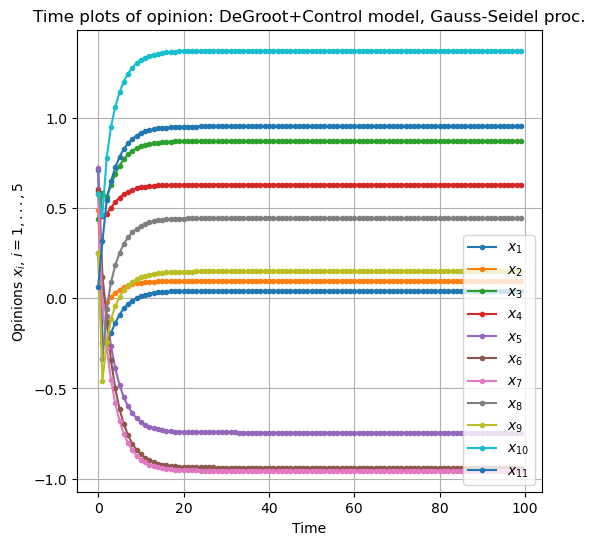

PyObject Text(0.5, 1.0, 'Time plots of opinion: DeGroot+Control model, Gauss-Seidel proc.')

In [59]:
x_os = COD_OSA_GS(rand(11),targets,Γo,K_f,Ao,Bo,0,0)
plot_opinions(mean.(x_os),100)

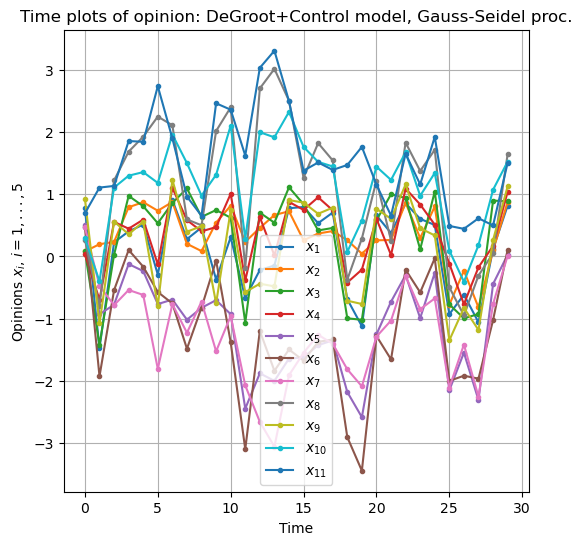

PyObject Text(0.5, 1.0, 'Time plots of opinion: DeGroot+Control model, Gauss-Seidel proc.')

In [63]:
x_os = COD_OSA_GS(rand(11),targets,Γo,K_f,Ao,Bo,0,1)
plot_opinions(mean.(x_os),30)

In [46]:
Ao[1:4,1:4]

4×4 Matrix{Float64}:
 0.080225   0.234243   0.271231   0.414301
 0.0795161  0.354894   0.294412   0.0628081
 0.317134   0.459252   0.0341387  0.189475
 0.0        0.0199706  0.383035   0.296333

In [47]:
Ao[5:7,5:7]

3×3 Matrix{Float64}:
 0.5659      0.0175184  0.416582
 0.00214302  0.787648   0.210209
 0.289305    0.3711     0.339595

# Three clusters -- smaller examples (8 agents, 3 players)

In [141]:
A = zeros(8,8)
A[1,1] = 2*rand(1)'*rand(1)
A[1,2] = 2*rand(1)'*rand(1)
A[1,3] = 2*rand(1)'*rand(1)
A[1,4] = 2*rand(1)'*rand(1)
A[1,6] = 2*rand(1)'*rand(1)
A[2,1] = 2*rand(1)'*rand(1)
A[2,2] = 2*rand(1)'*rand(1)
A[2,3] = 2*rand(1)'*rand(1)
A[3,1] = 2*rand(1)'*rand(1)
A[3,2] = 2*rand(1)'*rand(1)
A[3,3] = 2*rand(1)'*rand(1)
A[4,1] = 2*rand(1)'*rand(1)
A[4,4] = 2*rand(1)'*rand(1)
A[4,5] = 2*rand(1)'*rand(1)
A[4,8] = 2*rand(1)'*rand(1)
A[5,4] = 2*rand(1)'*rand(1)
A[5,5] = 2*rand(1)'*rand(1)
A[5,7] = 2*rand(1)'*rand(1)
A[6,6] = 2*rand(1)'*rand(1)
A[6,7] = 2*rand(1)'*rand(1)
A[6,8] = 2*rand(1)'*rand(1)
A[7,6] = 2*rand(1)'*rand(1)
A[7,7] = 2*rand(1)'*rand(1)
A[8,4] = 2*rand(1)'*rand(1)
A[8,6] = 2*rand(1)'*rand(1)
A[8,8] = 2*rand(1)'*rand(1)
# S = A'*A
Ao = rs_ize(A)
#As = rs_ize(S)

Bo = 2*rand(8,3)
Γo = 0.01*ones(3)
#targets = [ones(8) -1*ones(8) 0.1*ones(8)]
t1 = [1;1;1;1;0;1;1;0]
t2 = [-2;0;0;-2;-2;0;0;-2]
t3 = [0.1;0;0;0.1;0;0.1;0;0.1]
targets = [t1 t2 t3]
K_f = 100
x8_init =[1;1;1;-1;-1;0;0;0;];

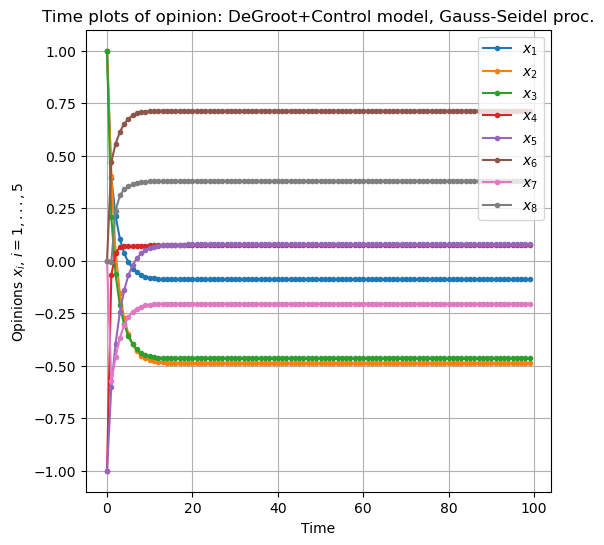

PyObject Text(0.5, 1.0, 'Time plots of opinion: DeGroot+Control model, Gauss-Seidel proc.')

In [142]:
x_os = COD_OSA_GS(x8_init,targets,Γo,K_f,Ao,Bo,0,0)
plot_opinions(x_os,100)
#plot_opinions(mean.(x_os),100)

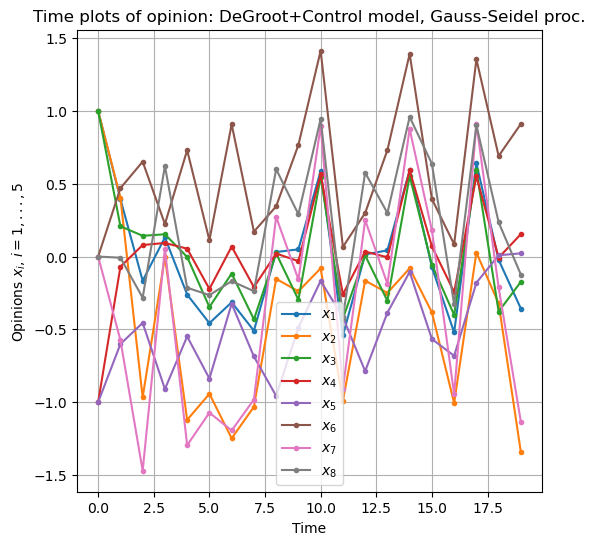

PyObject Text(0.5, 1.0, 'Time plots of opinion: DeGroot+Control model, Gauss-Seidel proc.')

In [143]:
x_os = COD_OSA_GS_1p(x8_init,targets,Γo,K_f,Ao,Bo,0,1)
plot_opinions(x_os,20)
#plot_opinions(mean.(x_os),100)

In [127]:
Ao

8×8 Matrix{Float64}:
 0.0993618  0.440158  0.125251  0.0852493  …  0.24998    0.0        0.0
 0.261634   0.463835  0.274531  0.0           0.0        0.0        0.0
 0.223664   0.39392   0.382415  0.0           0.0        0.0        0.0
 0.183473   0.0       0.0       0.167003      0.0        0.0        0.482449
 0.0        0.0       0.0       0.282935      0.0        0.409627   0.0
 0.0        0.0       0.0       0.0        …  0.794981   0.0613809  0.143638
 0.0        0.0       0.0       0.0           0.0911648  0.908835   0.0
 0.0        0.0       0.0       0.326345      0.131158   0.0        0.542497

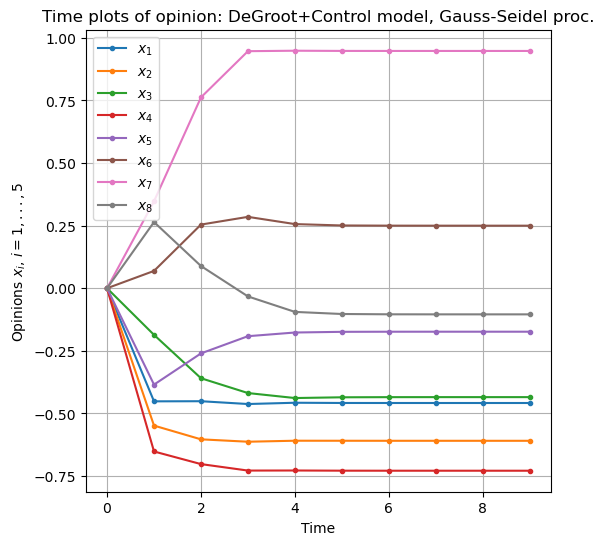

PyObject Text(0.5, 1.0, 'Time plots of opinion: DeGroot+Control model, Gauss-Seidel proc.')

In [96]:
x_os, p_reord = COD_OSA_GS_1perm(x8_init,targets,Γo,K_f,Ao,Bo,1)
plot_opinions(x_os,10)

In [133]:
x_os, u_os = COD_OSA_J_targets_DeGroot(x8_init,targets,Γo,K_f,Ao,Bo,-10,10,0)

([1.0 1.0076915271971925 … 6.502923805062154e7 -7.281908873987237e7; 1.0 1.529792128432673 … 1.0195738376376715e8 -1.3249355634301873e8; … ; 0.0 0.46026164030555455 … 3.966013113313219e7 -1.6797664953906572e8; 0.0 0.49160663060224996 … 1.661291437649064e8 -2.3313231554952314e8], [0.21162617666035877 -0.36879678039288083 … 5.786226505036511e7 -8.907456471643558e7; 0.2630190702172683 -0.3159965647057924 … 6.135835913318027e7 -7.718790968395607e7; 0.1057784193289161 -0.3640148981199563 … 6.210641840757177e7 -9.843820742807601e7])

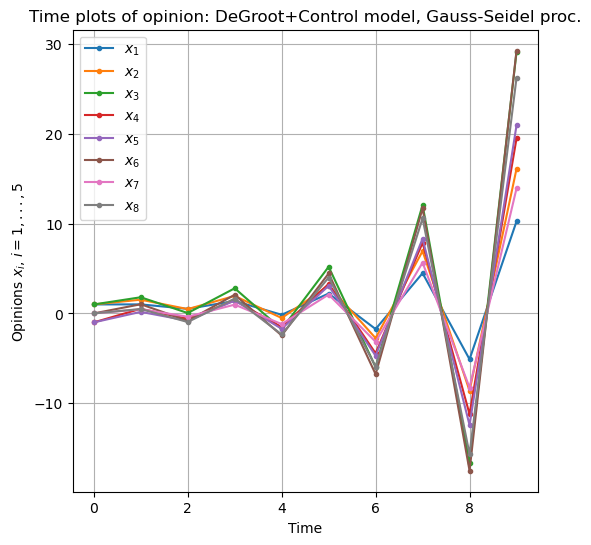

PyObject Text(0.5, 1.0, 'Time plots of opinion: DeGroot+Control model, Gauss-Seidel proc.')

In [134]:
plot_opinions(x_os,10)

In [99]:
p_r = RandomPermutation(5)

(1,2,3)(4)(5)

In [100]:
p_r[5]

5

In [104]:
perm = RandomPermutation[8]

4

In [111]:
perm = RandomPermutation(3)
Acg = A_cl_G(Ao,Bo,Γo,perm)
abs.(eigvals(Acg))

8-element Vector{Float64}:
 1.483065296055832e-17
 1.7820276402921154e-17
 1.7820276402921154e-17
 2.2926122803592867e-18
 1.3988872980673164e-18
 8.5664044973867e-18
 8.5664044973867e-18
 0.5329255037611069

In [112]:
A = zeros(8,8)
A[1,1] = 2*rand(1)'*rand(1)
A[1,2] = 2*rand(1)'*rand(1)
A[1,3] = 2*rand(1)'*rand(1)
A[1,4] = 2*rand(1)'*rand(1)
A[1,6] = 2*rand(1)'*rand(1)
A[2,1] = 2*rand(1)'*rand(1)
A[2,2] = 2*rand(1)'*rand(1)
A[2,3] = 2*rand(1)'*rand(1)
A[3,1] = 2*rand(1)'*rand(1)
A[3,2] = 2*rand(1)'*rand(1)
A[3,3] = 2*rand(1)'*rand(1)
A[4,1] = 2*rand(1)'*rand(1)
A[4,4] = 2*rand(1)'*rand(1)
A[4,5] = 2*rand(1)'*rand(1)
A[4,8] = 2*rand(1)'*rand(1)
A[5,4] = 2*rand(1)'*rand(1)
A[5,5] = 2*rand(1)'*rand(1)
A[5,7] = 2*rand(1)'*rand(1)
A[6,6] = 2*rand(1)'*rand(1)
A[6,7] = 2*rand(1)'*rand(1)
A[6,8] = 2*rand(1)'*rand(1)
A[7,6] = 2*rand(1)'*rand(1)
A[7,7] = 2*rand(1)'*rand(1)
A[8,4] = 2*rand(1)'*rand(1)
A[8,6] = 2*rand(1)'*rand(1)
A[8,8] = 2*rand(1)'*rand(1)
# S = A'*A
Ao = rs_ize(A)
#As = rs_ize(S)

Bo = 2*rand(8,4)
Γo = 0.01*ones(4)
#targets = [ones(8) -1*ones(8) 0.1*ones(8)]
t1 = [1;0;0;1;0;1;0;0]
t2 = [-1;0;0;-1;0;0;0;-1]
t3 = [0.1;0;0;0.1;0;0.1;0;0.1]
t4 = rand(8)
targets = [t1 t2 t3 t4]
K_f = 100

100

In [116]:
perm = RandomPermutation(4)
Acg = A_cl_G(Ao,Bo,Γo,perm)
abs.(eigvals(Acg))

8-element Vector{Float64}:
 8.333352091876629e-18
 2.316852453325193e-18
 2.316852453325193e-18
 0.0
 9.81447674119033e-18
 9.81447674119033e-18
 2.7106324685788e-17
 0.4385161249524959

In [117]:
AcJ = A_cl_J(Ao,Bo,Γo)
abs.(eigvals(AcJ))

8-element Vector{Float64}:
 2.2116177907894503
 0.5838649911066197
 0.25388603462210074
 0.30669860285605277
 0.3956193232381559
 0.3956193232381559
 0.7281358437306108
 0.7762016026665579

# Mazalov et al. examples: 

## Example in sec 4.1: Complete graph on 10 agent nodes, four players

- Players $1,2,3,4$ influence agents $1,4,6,9$.
- Control cost gamma = $0.01$ for all players
- Target values are $(0.5, 0.7,0.2, 0.3)$
- Initial opinions are $(0.5;0.7;0.4;0.4;0.8;0.7;0.9;0.6;0.3;0.5)$
- Final opinions (equilibrium state): $(1.909;0.425;0.425;5.967;0.425;-4.028;0.425;0.425;-2.049;0.425)$
- Summary: Agents without direct player influence reach consensus value $0.425$ which is average target value.
- Equilibrium values of the controls (eyeballing the graph): $u_1 \approx 1.8$, $u_2 \approx 5.8$,$u_3 \approx -4.2$ and $u_4 \approx -2.2$



In [49]:
#Parameters for Mazalov example sec. 4.1
x_init = [0.5;0.7;0.4;0.4;0.8;0.7;0.9;0.6;0.3;0.5]
#x_init = 0.1*ones(10)
#x_init = rand(10)
#influence_coeffs = rand(length(x_init))
influence_coeffs = ones(length(x_init))
#influence_coeffs = [0.7558141095359378
# 0.2403640732400053
# 0.5952306328026249
# 0.40760391850133837
# 0.4671391297514901
# 0.2362386421735686
# 0.7357474821183768
#0.8289131849211209
#0.639675653316676
#0.21388289000597238]
id = Array{Float64}(I(length(x_init)))
A = JMGW_Stochastic_matrix_generator_complete_graph(influence_coeffs)
B = [id[:,1] id[:,4] id[:,6] id[:,9]]

x1_hat = 0.5
x2_hat = 0.7
x3_hat = 0.2
x4_hat = 0.3


targets = [x1_hat*id[:,1] x2_hat*id[:,4] x3_hat*id[:,6] x4_hat*id[:,9]]
γ = 0.01*ones(size(targets,2))
#γ = 0.02*rand(size(targets,2))

u_min = -10
u_max = 10
#For reference, x_eq from the paper cited above is:
x_eq = [1.909;0.425;5.967;0.425;-4.028;0.425;0.425;-2.049;0.425]
K_f = 50 #horizon
proj_flag = 0

0

[0.4992574257700007, 0.4250000011901248, 0.4250000011901248, 0.6972772253852587, 0.4250000011901249, 0.20222772744963807, 0.4250000011901249, 0.4250000011901249, 0.30123762614418653, 0.4250000011901249]


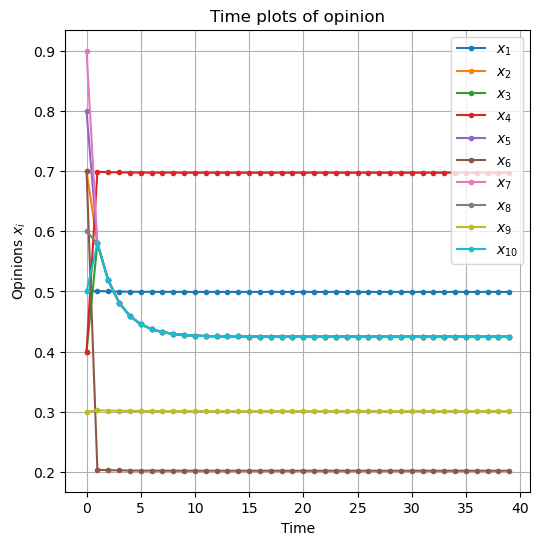

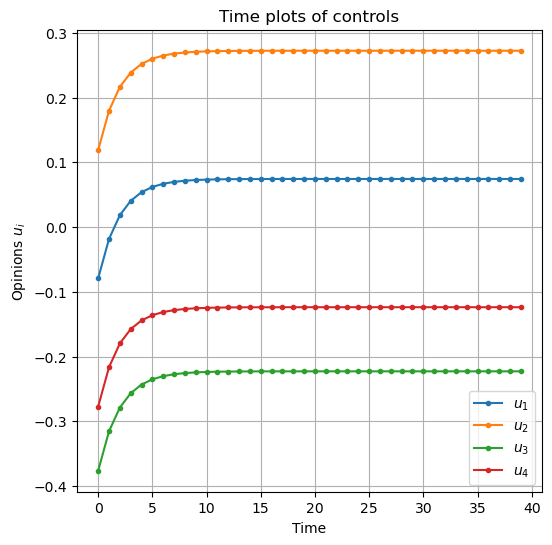

In [50]:
x_os, u_os = COD_OSA_J_targets_DeGroot(x_init,targets,γ,K_f,A,B,u_min,u_max,proj_flag)
plot_horiz = 40
save_flag_x = 1
fig_no_x = 2
save_flag_u = 1
fig_no_u = 2
plot_opinions(x_os,plot_horiz,fig_no_x,save_flag_x)
plot_controls(u_os,plot_horiz,fig_no_u,save_flag_u)
println(x_os[:,end])
#println(influence_coeffs)

In [51]:
println(u_os[:,end])

[0.07425742457987587, 0.2722772241951339, -0.2227722737404868, -0.1237623750459384]


# Mazalov example 2 in section 7 (4 agents, 2 players)

- Complete graph
- Initial condition $x(0) = (0.7,0.4,0.4,0.4)$
- Influence coefficients $a_1 = 0.6, a_2 = a_3 = a_4 = 0.8$, $\gamma_1 = 0.1, \gamma_2 = 0.15$
- Players 1 affects agent 1 and player 2 affects agents 2
- Targets: $\bar{x}_1 = 0.8, \bar{x}_2 = 0.5$


In [47]:
#Parameters for Mazalov example sec. 4.1
x_init = [0.7;0.4;0.4;0.4]
#x_init = 0.1*ones(10)
#x_init = rand(10)
#influence_coeffs = rand(length(x_init))
#influence_coeffs = ones(length(x_init))
influence_coeffs = [0.6;0.8;0.8;0.8]

id = Array{Float64}(I(length(x_init)))
A = JMGW_Stochastic_matrix_generator_complete_graph(influence_coeffs)
B = [id[:,1] id[:,2]]
#=
A = [0.55 0.15 0.15 0.15; 0.2 0.4 0.2 0.2; 0.2 0.2 0.4 0.2; 0.2 0.2 0.2 0.4]
B = [1 0; 0 1; 0 0; 0 0];

x1_hat = 0.8
x2_hat = 0.5

p1 = [x1_hat;0;0;0]
p2 = [0;x2_hat;0;0]

targets_2 = [p1 p2]
=#
targets = [x1_hat*id[:,1] x2_hat*id[:,2]]
γ = [0.1;0.15]
#γ = 0.01*ones(size(targets,2))
#γ = 0.02*rand(size(targets,2))

u_min = -10
u_max = 10
#For reference, x_eq from the paper cited above is:
x_eq = [1.909;0.425;5.967;0.425;-4.028;0.425;0.425;-2.049;0.425]
K_f = 50 #horizon
proj_flag = 0

0

[0.7917431145473812, 0.5165137610450494, 0.654128437772452, 0.6541284377724519]


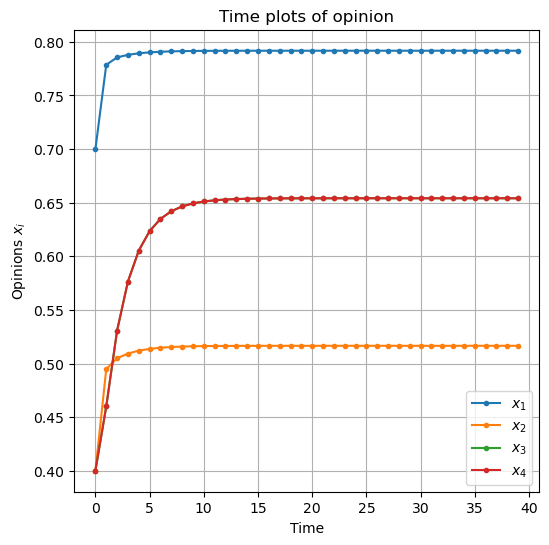

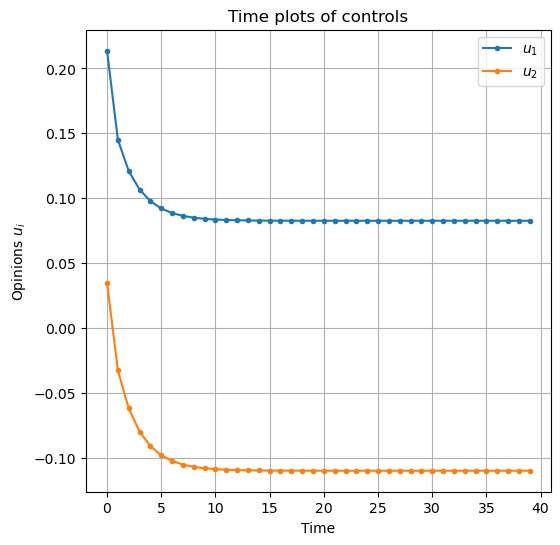

In [48]:
x_os, u_os = COD_OSA_J_targets_DeGroot(x_init,targets,γ,K_f,A,B,u_min,u_max,proj_flag)
plot_horiz = 40
save_flag_x = 1
fig_no_x = 4
save_flag_u = 1
fig_no_u = 4
plot_opinions(x_os,plot_horiz,fig_no_x,save_flag_x)
plot_controls(u_os,plot_horiz,fig_no_u,save_flag_u)
println(x_os[:,end])

# Comparison with Veetaseveera et al example.

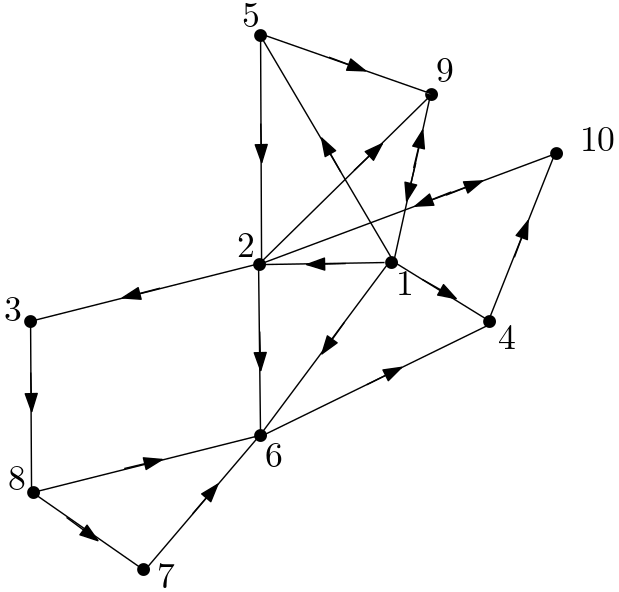

In [42]:
#Parameters
#Setting up the adjacency matrix Ad for the graph in Veetaseveera (Fig. 1, p.258)
Ad = Array{Float64}(zeros(10,10))
Ad[1,2] = 1.0
Ad[1,4] = 1.0
Ad[1,5] = 1.0
Ad[1,6] = 1.0
Ad[1,9] = 1.0
Ad[2,3] = 1.0
Ad[2,6] = 1.0
Ad[2,9] = 1.0
Ad[2,10] = 1.0
Ad[3,8] = 1.0
Ad[4,10] = 1.0
Ad[5,2] = 1.0
Ad[5,9] = 1.0
Ad[6,4] = 1.0
Ad[7,6] = 1.0
Ad[8,6] = 1.0
Ad[8,7] = 1.0
Ad[9,1]= 1.0
Ad[9,4] = 1.0
Ad[10,2] = 1.0

D_out = diagm([5.0; 4.0; 1.0; 1.0; 2.0; 1.0; 1.0; 2.0; 2.0; 1.0])
D_in = diagm([1.0; 3.0; 1.0; 3.0; 1.0; 4.0; 1.0; 1.0; 3.0; 2.0])
L = D_out - Ad
δ = 0.1
A = I(10) - δ*L #This A is row stochastic
#RS = rowsum(A)
#rho_A = maximum(abs.(eigvals(A)))

x1_hat = 2
x2_hat = -2

x_init = [1;2;-3;0;6;-5;4;3;-2;4]   #Called x_A in Veetaseveera et al.
#x_init = [4;-2;-2;-3;2;0;2;-1;1;0] #Called x_B in Veetaseveera et al.

#γ = ones(size(targets,2))
#γ = 0.02*rand(size(targets,2))
#γ = [0.01;0.01]
#γ = [0.1;0.005]
γ = [0.01;0.02]
u_min = -10
u_max = 10

K_f = 100 #horizon
proj_flag = 0
#=
#Case 1 UB, UB
B = [ones(length(x_init)) ones(length(x_init))]
=#
#=
#Case 2 TA, TA (but our way rather than Veetaseveera's way)
id = Array{Float64}(I(length(x_init)))
B = [id[:,5] id[:,7]]
targets = [x1_hat*id[:,5] x2_hat*id[:,7]]
=#

#Case 3 UB, TA (but our way rather than Veetaseveera's way)
id = Array{Float64}(I(length(x_init)))
#targets = [x1_hat*ones(length(x_init)) x2_hat*ones(length(x_init))]

#b1_targ = id[:,1] + id[:,2] + id[:,3] + id[:,4] + id[:,5]
#b2_targ = id[:,6] + id[:,7] + id[:,8] + id[:,9] + id[:,10]
b2_targ = id[:,1] + id[:,2] 
b1_targ = id[:,5] + id[:,9]
#B = [ones(length(x_init)) ones(length(x_init))]
B = [b1_targ b2_targ]
targets = [x1_hat*b1_targ x2_hat*b2_targ]

10×2 Matrix{Float64}:
 0.0  -2.0
 0.0  -2.0
 0.0  -0.0
 0.0  -0.0
 2.0  -0.0
 0.0  -0.0
 0.0  -0.0
 0.0  -0.0
 2.0  -0.0
 0.0  -0.0

[0.17760447480515315, -9.700101485932144e-9, 0.10227094011776369, 0.00296018184165474, 1.0000000094488497, 0.013967045095466347, 0.04379456887261486, 0.043794568617985384, 0.7256764649895766, 0.00031363069258530195]
[0.17883979460045368, -9.700189151917726e-9, 0.09642330296778587, 0.0026955267267477962, 1.0000000094487649, 0.012866358770085188, 0.04081181649490001, 0.04081181629119643, 0.7260299940170798, 0.00028226665331662317]
[0.12743235636073766, -0.08422281196966747]


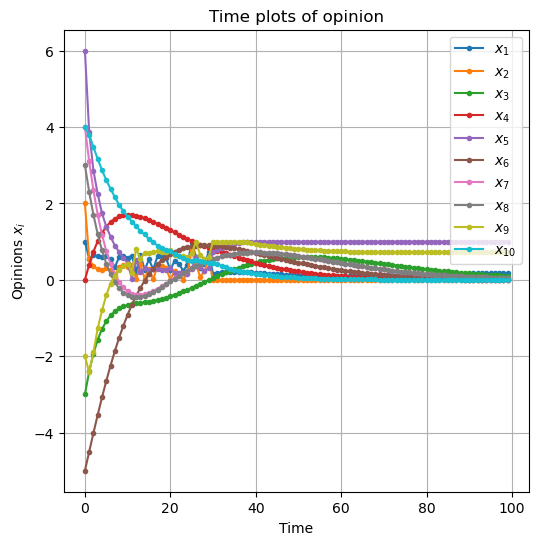

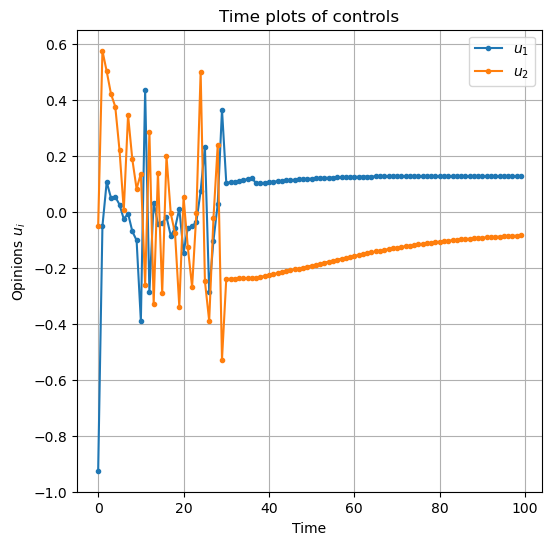

In [43]:
x_os, u_os = COD_OSA_J_targets_DeGroot(x_init,targets,γ,K_f,A,B,u_min,u_max,proj_flag)
plot_horiz = 100
save_flag_x = 0
fig_no_x = 6
save_flag_u = 0
fig_no_u = 6
plot_opinions(x_os,plot_horiz,fig_no_x,save_flag_x)
plot_controls(u_os,plot_horiz,fig_no_u,save_flag_u)
println(x_os[:,end-1])
println(x_os[:,end])
println(u_os[:,end])

In [44]:
perm_flag = 1
x_os1 = COD_OSA_GS_1p(x_init,targets,γ,K_f,A,B,proj_flag,perm_flag)

10×101 Matrix{Float64}:
  1.0  -1.77138   -1.67981   -0.990677  …  -1.29401  -1.53165   -1.28887
  2.0  -2.1862    -2.29801   -1.54926      -2.09822  -2.45111   -2.09474
 -3.0  -1.93      -1.291     -0.933563     -2.20246  -2.20323   -2.20387
  0.0   0.74       1.20394    1.39466      -2.20432  -2.20833   -2.20476
  6.0   4.06343    2.93054    2.73473       2.54513   2.02847    2.54365
 -5.0  -4.01      -3.0801    -2.25359   …  -2.20738  -2.20708   -2.20699
  4.0   2.34       1.181      0.414231     -2.20644  -2.20659   -2.2067
  3.0   1.7        0.7714     0.152087     -2.20644  -2.20659   -2.2067
 -2.0  -0.821393   0.102991   1.25266       1.43874   0.819281   1.44043
  4.0   3.48       2.45806    1.55465      -2.23245  -2.17505   -2.22598

[-1.5316527384810688, -2.451109564271256, -2.203225470143358, -2.2083251664291876, 2.028469410194659, -2.207081809533187, -2.2065920097921, -2.2065920097921, 0.8192809254594823, -2.1750503482750805]
[-1.2888725844740974, -2.09473913139521, -2.20387001067403, -2.204763543139869, 2.543651871823904, -2.206985299161886, -2.2066975053118667, -2.2066975053118667, 1.4404338787678266, -2.2259805382976108]


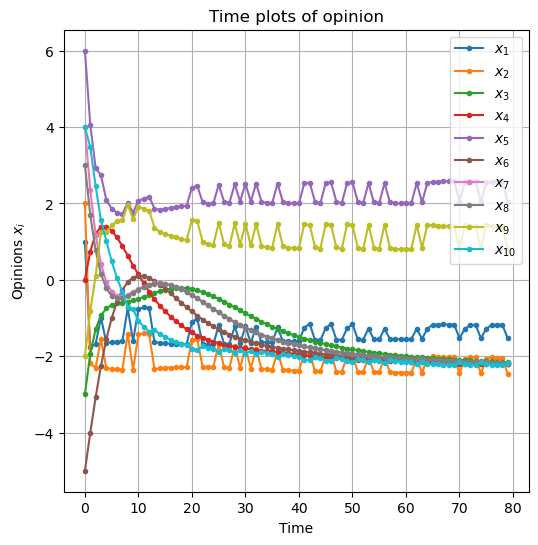

In [45]:
plot_horiz = 80
save_flag_x = 1
fig_no_x = 7
#save_flag_u = 0
#fig_no_u = 6
plot_opinions(x_os1,plot_horiz,fig_no_x,save_flag_x)
#plot_controls(u_os,plot_horiz,fig_no_u,save_flag_u)
println(x_os1[:,end-1])
println(x_os1[:,end])

In [61]:
testM=diagm(0=>[1,3,2])
eigvals(testM)
eigvecs(testM)
U=eigen(testM)
U.vectors
U.values

3-element Vector{Float64}:
 1.0
 2.0
 3.0

In [64]:
X = rand(4,4)
efd = eigen(Symmetric(X), 3:4)
println(efd.values)
println(efd.vectors)
println(reverse(efd.values, dims=1))
println(reverse(efd.vectors, dims=2))

[0.6085884985212751, 2.615331833774935]
[0.7732786277029375 -0.3449899537248714; -0.5429845355522784 -0.5712841501797787; 0.2203740705148375 -0.6312562350138745; -0.2421636371003283 -0.39513531522554085]
[2.615331833774935, 0.6085884985212751]
[-0.3449899537248714 0.7732786277029375; -0.5712841501797787 -0.5429845355522784; -0.6312562350138745 0.2203740705148375; -0.39513531522554085 -0.2421636371003283]


In [ ]:

K = size(x, 1)
ef = eigen(Symmetric(x), K-k+1:K) #k largest eigenvalues/vectors
ef.values
ef.vectors
reverse(ef.values, dims=1)    #If you want ordered largest to smallest
reverse(ef.vectors, dims=2)   #If you want ordered largest to smallest

In [66]:
k=2
K = size(A_rs, 1)
ef = eigen(A_rs)
ef.values[1:k]           #smallest k
ef.vectors[:, 1:k]       #smallest k
ef.values[K-k+1:K]       #largest k
ef.vectors[:, K-k+1:K]   #largest k

println(ef.values)
println(ef.vectors)
println(reverse(ef.values, dims=1))
println(reverse(ef.vectors, dims=2))

ComplexF64[0.5196206871619959 - 0.01616915492682254im, 0.5196206871619959 + 0.01616915492682254im, 0.7547032832861452 + 0.0im, 0.7999999999999997 + 0.0im, 0.8500523024962532 - 0.06517827822118431im, 0.8500523024962532 + 0.06517827822118431im, 0.8682888504237959 + 0.0im, 0.9188309434867817 - 0.06392585923043931im, 0.9188309434867817 + 0.06392585923043931im, 1.0000000000000004 + 0.0im]
ComplexF64[0.7811238599449319 - 0.0im 0.7811238599449319 + 0.0im -0.1910937102182332 + 0.0im 0.12309149097933024 + 0.0im 0.21555670175090288 - 0.11546154810810139im 0.21555670175090288 + 0.11546154810810139im 0.3066971148179122 + 0.0im -0.12210740203852946 - 0.06044079099907317im -0.12210740203852946 + 0.06044079099907317im -0.3162277660168374 + 0.0im; 0.4837115307428507 - 0.20598297598847248im 0.4837115307428507 + 0.20598297598847248im 0.11215641663777319 + 0.0im -0.12309149097933436 + 0.0im 0.07962769199163026 - 0.14605902456557415im 0.07962769199163026 + 0.14605902456557415im 0.0013427362964660906 + 0.0

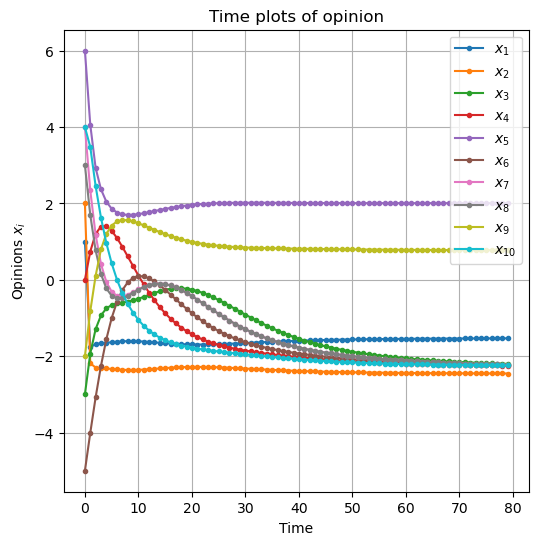

In [49]:
proj_flag = 0
perm_flag = 0
x_os_2 = COD_OSA_GS(x_init,targets,γ,K_f,A,B,proj_flag,perm_flag)

plot_horiz = 80
save_flag_x = 0
fig_no_x = 8
#save_flag_u = 0
#fig_no_u = 6
plot_opinions(x_os_2,plot_horiz,fig_no_x,save_flag_x)